<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/Sonia_LondonBikeSharing_borrador_123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install gdown
#!pip install tensorflow-gpu

In [2]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

In [4]:
import seaborn as sns

In [5]:
data = pd.read_csv('/content/london_merged.csv')

Los datos del conjunto de datos de ciclismo bicicletas se agrupan por "Hora de inicio", lo que representa el recuento de nuevas bicicletas compartidas agrupadas por hora. Las acciones de larga duración no se toman en cuenta.

El propósito es intentar predecir las futuras bicicletas compartidas.

In [7]:
data.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [ ]:
data.shape

(17414, 10)

In [ ]:
17414

Vemos que tenemos una cantidad bastante buena de muestras.

Las variables son:

"timestamp" - timestamp field for grouping the data

"cnt" - the count of a new bike shares

"t1" - real temperature in C

"t2" - temperature in C "feels like"

"hum" - humidity in percentage

"windspeed" - wind speed in km/h

"weathercode" - category of the weather

"isholiday" - boolean field - 1 holiday / 0 non holiday

"isweekend" - boolean field - 1 if the day is weekend

"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# EDA - Exploratory Data Analysis

In [8]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [9]:
data.isnull().values.sum()

0

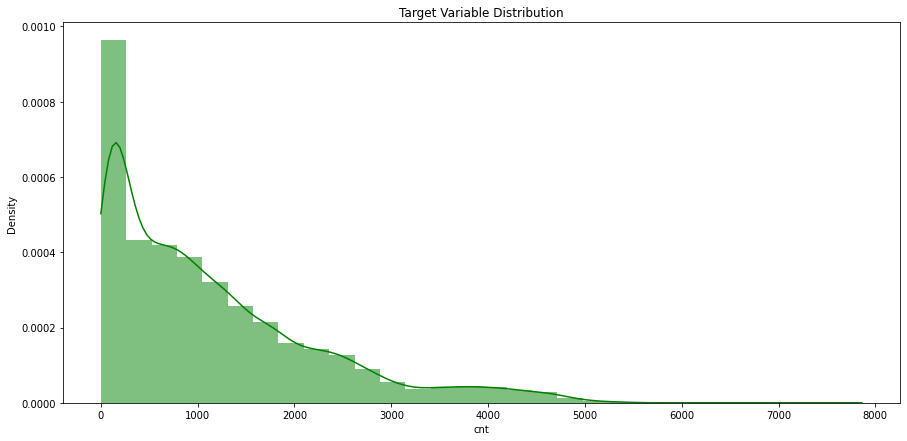

In [29]:
plt.figure(figsize=(15, 7))
#sns.distplot(data[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
sns.histplot(data[target], color='g', kde=True, stat="density", linewidth=0, bins=30)
plt.title('Target Variable Distribution')
plt.show()


In [76]:
np.sqrt(data.cnt.var())

1085.1080679362167

In [73]:
data[data.cnt == data.cnt.max()]

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year
timestamp,,,,,,,,,,,,,,
2015-07-09 17:00:00,7860,23.0,22.0,27.0,11.0,1.0,0.0,0.0,1.0,17,3,9,7,2015


In [ ]:
data[data.cnt == data.cnt.min()]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
2015,2015-03-29 01:00:00,0,10.5,8.5,77.0,33.0,7.0,0.0,1.0,0.0


In [ ]:
data.head(25)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [30]:
#convertir "timestamp" a formato datatime para poder separar la información en variables
#data['timestamp'] = pd.to_datetime(data.iloc['timestamp'])

data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
'''
data["year"] = data['timestamp'].dt.year #años
data["month"] = data['timestamp'].dt.month #meses
data["day_of_month"] = data['timestamp'].dt.day #día del mes
data["day_of_week"] = data['timestamp'].dt.weekday #dia de la semana
data["hour"] = data['timestamp'].dt.hour #horas
data.head()
'''
data['hour'] = data.index.hour #horas
data["day_of_week"] = data.index.weekday
data["day_of_month"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year

In [31]:
#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

In [ ]:
data.head(4)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year
timestamp,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1,2015
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1,2015
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1,2015
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1,2015


In [ ]:
data.shape[0]

17414

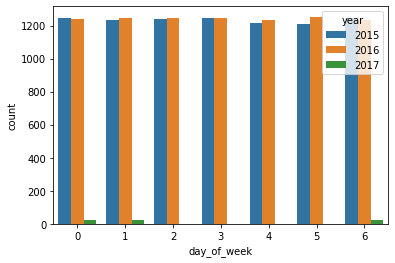

In [ ]:
sns.countplot(x="day_of_week", hue="year", data=data) 

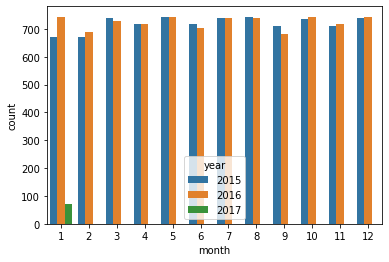

In [ ]:
sns.countplot(x="month", hue="year", data=data)

In [ ]:
# vemos que tenemos datos de los años 2015 y 2016 completos
# y del año 2017 solo diponemos de un mes.

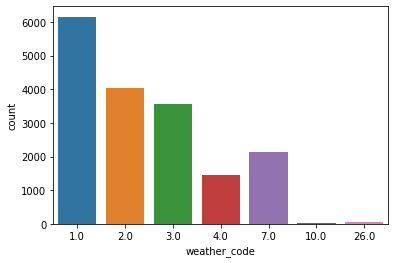

In [ ]:
sns.countplot(x="weather_code", data=data)

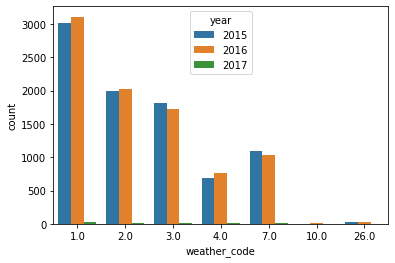

In [ ]:
sns.countplot(x="weather_code", hue = 'year', data=data)

In [ ]:
#como es de esperar los días con un tiempo más soleado se utilizan más las 
#bicicletas, como es de esperar.

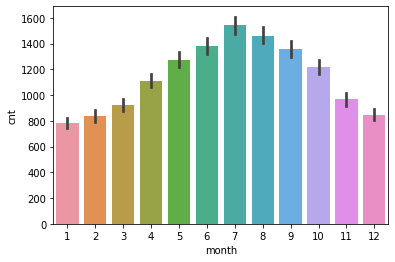

In [ ]:
sns.barplot(x="month", y="cnt", data=data) #ojo, en enero tenemos más datos, quitarlo

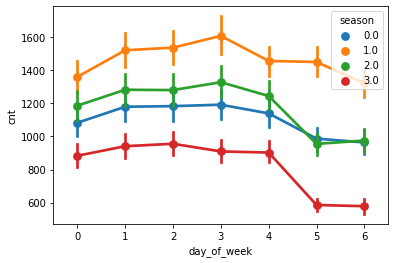

In [ ]:
sns.pointplot(data=data, x="day_of_week", y="cnt", hue="season")

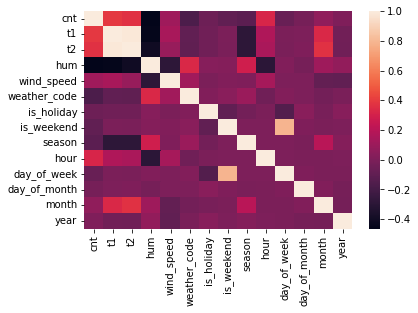

In [ ]:
sns.heatmap(data.corr())

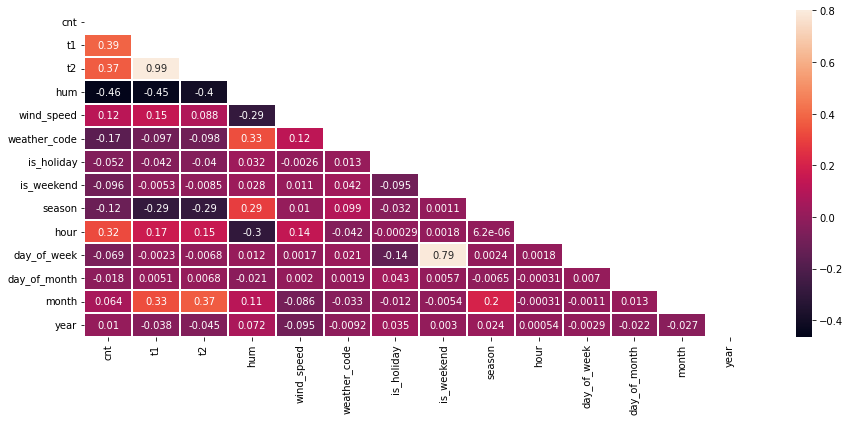

In [ ]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1);

In [ ]:
#como es normal t1 y t2 están estrechamente correlacionadas
#además "is_weekend" (fin de semana) y "day_of_week" también están 
#bastante corelacionadas, como es normal.

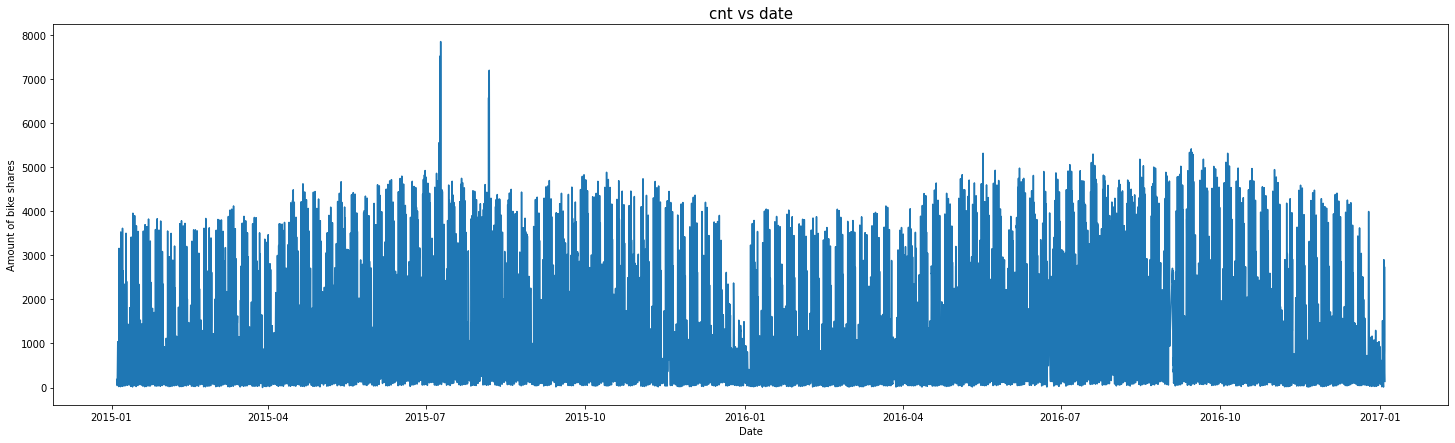

In [32]:
plt.figure(figsize=(25, 7))
ax = sns.lineplot(data=data,x="timestamp",y="cnt")
ax.set_title("cnt vs date", fontsize=15)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel('Amount of bike shares', fontsize=10)
plt.show()

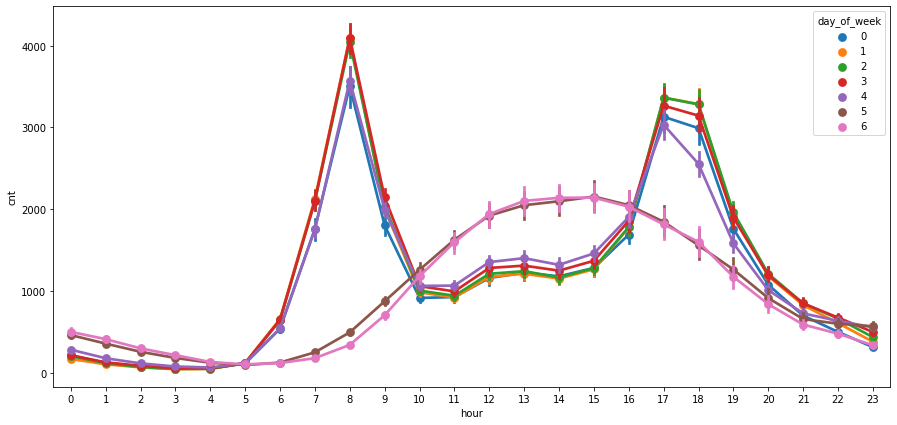

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='day_of_week', data=data)

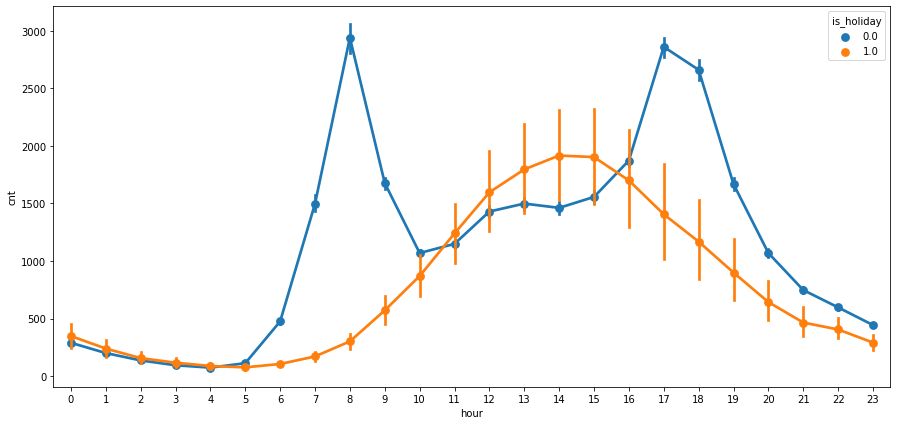

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=data)

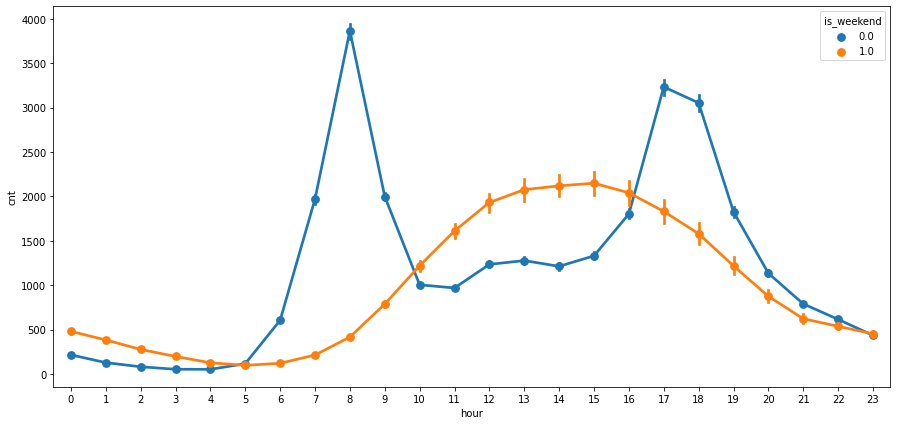

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_weekend', data=data)

In [ ]:
#vemos claramente que entre semana la gente se mueve en bicicleta con mayor frecuencia alrededor de las 8 y alrededor de las 18
#en cambio el fin de semana, se utilizan menos y además, los valores están más dispersos,
#encontrando mayor frecuencia de uso al medio dia.

In [ ]:
'''
# interpolate weather, temp, atemp, humidity, windspeed
all_df["weather"] = all_df["weather"].interpolate(method='time').apply(np.round)
all_df["temp"] = all_df["temp"].interpolate(method='time')
all_df["atemp"] = all_df["atemp"].interpolate(method='time')
all_df["humidity"] = all_df["humidity"].interpolate(method='time').apply(np.round)
all_df["windspeed"] = all_df["windspeed"].interpolate(method='time')
'''

'\n# interpolate weather, temp, atemp, humidity, windspeed\nall_df["weather"] = all_df["weather"].interpolate(method=\'time\').apply(np.round)\nall_df["temp"] = all_df["temp"].interpolate(method=\'time\')\nall_df["atemp"] = all_df["atemp"].interpolate(method=\'time\')\nall_df["humidity"] = all_df["humidity"].interpolate(method=\'time\').apply(np.round)\nall_df["windspeed"] = all_df["windspeed"].interpolate(method=\'time\')\n'

In [ ]:
# Mas preproceso 
#data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Preprocessing

In [33]:
data_final = data[['t1',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season',
 'cnt']]

 #si no tengo indexado timestamp deberé añadirlo como "label"

In [34]:
data_final.head()

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
timestamp,,,,,,,,
2015-01-04 00:00:00,3.0,93.0,6.0,3.0,0.0,1.0,3.0,182
2015-01-04 01:00:00,3.0,93.0,5.0,1.0,0.0,1.0,3.0,138
2015-01-04 02:00:00,2.5,96.5,0.0,1.0,0.0,1.0,3.0,134
2015-01-04 03:00:00,2.0,100.0,0.0,1.0,0.0,1.0,3.0,72
2015-01-04 04:00:00,2.0,93.0,6.5,1.0,0.0,1.0,3.0,47


## train / test

In [35]:
train_split = 0.9 
num_data = len(data_final)
num_train = int(train_split * num_data)
num_train

num_test = num_data - num_train
num_test

train, test = data_final.iloc[0:num_train], data_final.iloc[(num_train):len(data_final)]
print(data_final.shape, train.shape, test.shape)

(17414, 8) (15672, 8) (1742, 8)


In [ ]:
int(train.shape[0]) + int(test.shape[0])

17414

In [ ]:
#Escalamos datos para un mejor rendimiento de la red, ya que las entradas grandes
#relentizan el aprendizaje, pueden hacer que la red converja
#un menor coste comuptacional

#problema que encuentro, que la red es muy sensible a reescalar con MinMaxScaler
#estandarizar, no es lo más óptimo ya que no tenemos una distribución gaussiana
#encuetro por internet RobustScarler() que parece que me ayuda a conseguir predecir bien mi problema


ROBUST SCALER
Escale características usando estadísticas que son robustas para los valores atípicos.

Este escalador elimina la mediana y escala los datos de acuerdo con el rango de cuantiles (el valor predeterminado es IQR: rango intercuartílico). El IQR es el rango entre el primer cuartil (cuartil 25) y el tercer cuartil (cuartil 75).

In [60]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
    train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [61]:
cnt_transformer = RobustScaler() #standard scaler , dividir entre desv estandard
cnt_transformer = cnt_transformer.fit(train[['cnt']])
train['cnt'] = cnt_transformer.transform(train[['cnt']])
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#ESTA NO ME OFRECE BUEN RESULTADO 
'''
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
#cnt_transformer = scaler.fit_transform(train[['cnt']]) 

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


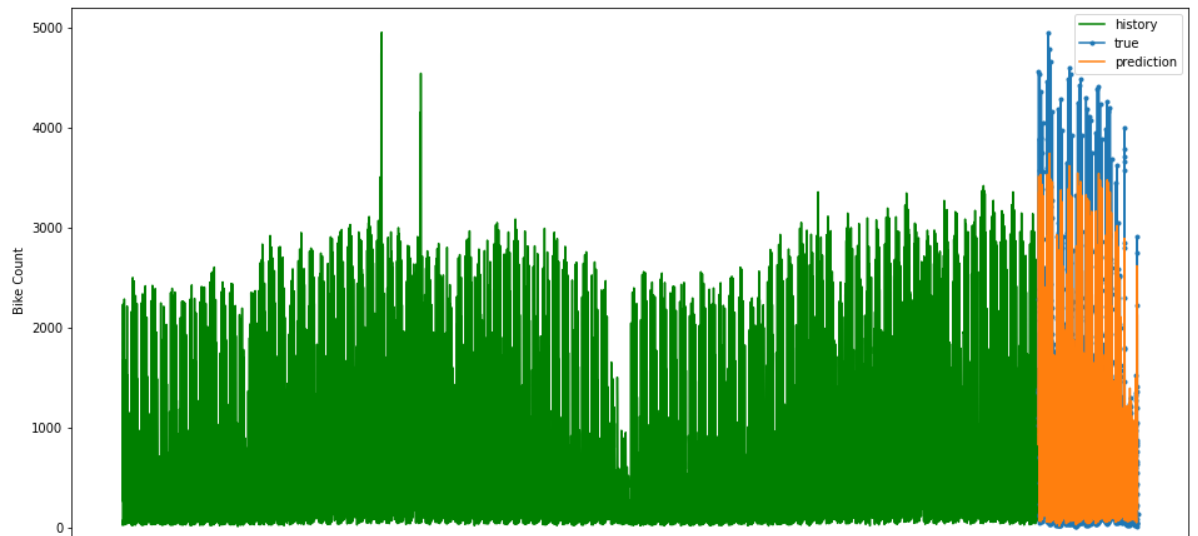

In [ ]:
train.tail(10)

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
timestamp,,,,,,,,
2016-10-22 22:00:00,-0.3750,0.425,-0.818182,1.0,0.0,1.0,2.0,-0.184573
2016-10-22 23:00:00,-0.3750,0.425,-0.909091,2.0,0.0,1.0,2.0,-0.215565
2016-10-23 00:00:00,-0.5000,0.675,-1.000000,3.0,0.0,1.0,2.0,-0.275482
2016-10-23 01:00:00,-0.5000,0.675,-1.090909,3.0,0.0,1.0,2.0,-0.294766
2016-10-23 02:00:00,-0.5625,0.825,-0.909091,2.0,0.0,1.0,2.0,-0.345730
2016-10-23 03:00:00,-0.6250,0.825,-0.818182,2.0,0.0,1.0,2.0,-0.440771
2016-10-23 04:00:00,-0.6250,0.975,-0.818182,2.0,0.0,1.0,2.0,-0.486915
2016-10-23 05:00:00,-0.6250,0.675,-1.000000,3.0,0.0,1.0,2.0,-0.516529
2016-10-23 06:00:00,-0.6250,0.825,-0.772727,3.0,0.0,1.0,2.0,-0.516529


In [ ]:
print(train.cnt.max())
print(train.cnt.min())

1.0
0.0


In [ ]:
test.head(20)

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
15672,-0.6250,0.675,-0.818182,2.0,0.0,1.0,2.0,0.062728
15673,-0.4375,0.275,-0.454545,2.0,0.0,1.0,2.0,0.148725
15674,-0.3125,0.025,0.000000,3.0,0.0,1.0,2.0,0.273169
15675,-0.1250,-0.200,0.636364,2.0,0.0,1.0,2.0,0.382639
15676,-0.1250,-0.325,0.818182,2.0,0.0,1.0,2.0,0.436463
15677,-0.0625,-0.300,0.818182,2.0,0.0,1.0,2.0,0.490894
15678,0.0000,-0.525,0.909091,2.0,0.0,1.0,2.0,0.443950
15679,0.0000,-0.425,0.727273,2.0,0.0,1.0,2.0,0.485026
15680,-0.1250,-0.325,0.727273,2.0,0.0,1.0,2.0,0.416835
15681,-0.1250,-0.200,0.818182,3.0,0.0,1.0,2.0,0.367665


In [ ]:
print(test.cnt.max())
print(test.cnt.min())
print(train.cnt.max())
print(train.cnt.min())

2.819559228650138
-0.5840220385674931
4.823002754820936
-0.5902203856749312


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


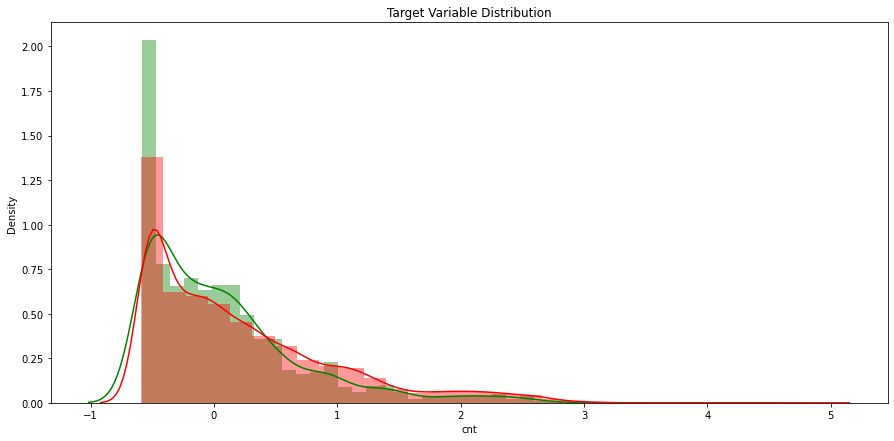

In [ ]:
plt.figure(figsize=(15, 7))
sns.distplot(test.cnt, color='g', bins=30)
sns.distplot(train.cnt, color='r',bins=30)
plt.title('Target Variable Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

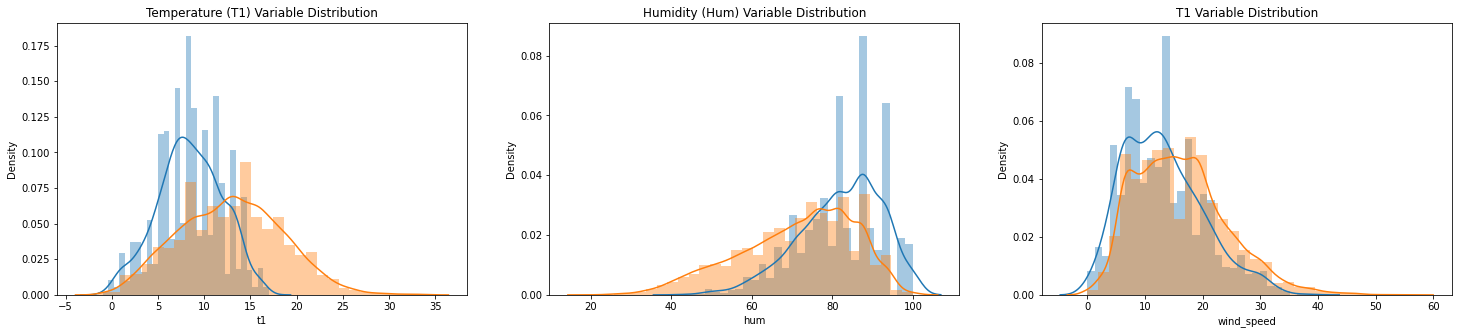

In [44]:
plt.figure(figsize=(25, 5))
plt.subplot(1,3,1)
plt.title('Temperature (T1) Variable Distribution')
sns.distplot(test.t1, bins=30, label='t1 test')
sns.distplot(train.t1, bins=30, label='t1 train')
#plt.figure(figsize=(7, 5))
plt.subplot(1,3,2)
plt.title('Humidity (Hum) Variable Distribution')
sns.distplot(test.hum, bins=30, label = 'hum test')
sns.distplot(train.hum, bins=30, label= 'hum train')
#plt.figure(figsize=(7, 5))
plt.subplot(1,3,3)
plt.title('Wind speed Variable Distribution')
sns.distplot(test.wind_speed, bins=30, label = 'wind speed test')
sns.distplot(train.wind_speed, bins=30, label= 'wind speed train')
plt.title('T1 Variable Distribution')
plt.show()

In [ ]:
train.cnt

timestamp
2015-01-04 00:00:00   -0.464876
2015-01-04 01:00:00   -0.495179
2015-01-04 02:00:00   -0.497934
2015-01-04 03:00:00   -0.540634
2015-01-04 04:00:00   -0.557851
                         ...   
2016-10-23 03:00:00   -0.440771
2016-10-23 04:00:00   -0.486915
2016-10-23 05:00:00   -0.516529
2016-10-23 06:00:00   -0.516529
2016-10-23 07:00:00   -0.471074
Name: cnt, Length: 15672, dtype: float64

In [45]:
#time_steps = lag = # lag is the number of previous values to consider for predicting next one
def create_dataset(X, y, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values # slice of "lag" length starting at i
        dataX.append(v)        
        dataY.append(y.iloc[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [46]:
#time_steps = 10
time_steps = 48 # 2 dias --> 48 horas

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

#print(X_train.shape, y_train.shape)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# reshape to [samples, time_steps, n_features]

(15624, 48, 8)
(1694, 48, 8)
(15624,)
(1694,)


In [47]:
print(X_train[-1, 0:]) #48 time steps y 8 features, var. contexto
print(X_test[-1, 0:]) 

[[1.000e+01 8.800e+01 1.200e+01 2.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.087e+03]
 [1.000e+01 8.800e+01 1.400e+01 2.000e+00 0.000e+00 0.000e+00 2.000e+00
  4.253e+03]
 [1.000e+01 8.800e+01 1.500e+01 7.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.273e+03]
 [1.050e+01 8.500e+01 1.500e+01 7.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.163e+03]
 [1.150e+01 7.950e+01 1.700e+01 2.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.128e+03]
 [1.200e+01 7.700e+01 1.600e+01 3.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.435e+03]
 [1.300e+01 7.200e+01 1.400e+01 3.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.553e+03]
 [1.300e+01 6.950e+01 1.500e+01 3.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.414e+03]
 [1.350e+01 6.500e+01 1.300e+01 3.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.499e+03]
 [1.300e+01 7.200e+01 1.200e+01 3.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.116e+03]
 [1.300e+01 7.200e+01 9.000e+00 3.000e+00 0.000e+00 0.000e+00 2.000e+00
  3.091e+03]
 [1.200e+01 7.700e+01 1.000e+01 3.000e+00 0.000e+00 0.000e+00 2.0

# (ESTE NO SALE BIEN) LSTM con los datos de 'cnt' escalados con MinMaxScaler

Este modelo luego lo borraré porque no predice bien, he escalado mal o este métodos no es suficientemente robusto a la distribución de datos que tenemos. 

In [ ]:
model_0 = Sequential()
model_0.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))  # input_shape=[time steps, features]
model_0.add(Dense(1))
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_0 = Sequential()
model_0.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2])))
model_0.add(Dense(units = 512, activation = 'relu'))
model_0.add(Dense(units = 1, activation = 'linear'))
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1067008   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,330,177
Trainable params: 1,330,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_0.fit(X_train, y_train, epochs=20, batch_size=2, verbose=2)

Epoch 1/20
7812/7812 - 154s - loss: 0.0058 - 154s/epoch - 20ms/step
Epoch 2/20
7812/7812 - 148s - loss: 0.0015 - 148s/epoch - 19ms/step
Epoch 3/20
7812/7812 - 149s - loss: 0.0011 - 149s/epoch - 19ms/step
Epoch 4/20
7812/7812 - 148s - loss: 8.5633e-04 - 148s/epoch - 19ms/step
Epoch 5/20
7812/7812 - 148s - loss: 8.0393e-04 - 148s/epoch - 19ms/step
Epoch 6/20
7812/7812 - 148s - loss: 7.4549e-04 - 148s/epoch - 19ms/step
Epoch 7/20
7812/7812 - 149s - loss: 6.9382e-04 - 149s/epoch - 19ms/step
Epoch 8/20
7812/7812 - 148s - loss: 6.3393e-04 - 148s/epoch - 19ms/step
Epoch 9/20
7812/7812 - 147s - loss: 6.2448e-04 - 147s/epoch - 19ms/step
Epoch 10/20
7812/7812 - 148s - loss: 6.0991e-04 - 148s/epoch - 19ms/step
Epoch 11/20
7812/7812 - 147s - loss: 5.4508e-04 - 147s/epoch - 19ms/step
Epoch 12/20
7812/7812 - 146s - loss: 5.2565e-04 - 146s/epoch - 19ms/step
Epoch 13/20
7812/7812 - 146s - loss: 5.4544e-04 - 146s/epoch - 19ms/step
Epoch 14/20
7812/7812 - 146s - loss: 5.0086e-04 - 146s/epoch - 19ms/step

In [ ]:
# make predictions

y_pred_test = model_0.predict(X_test)
y_pred_train = model_0.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)


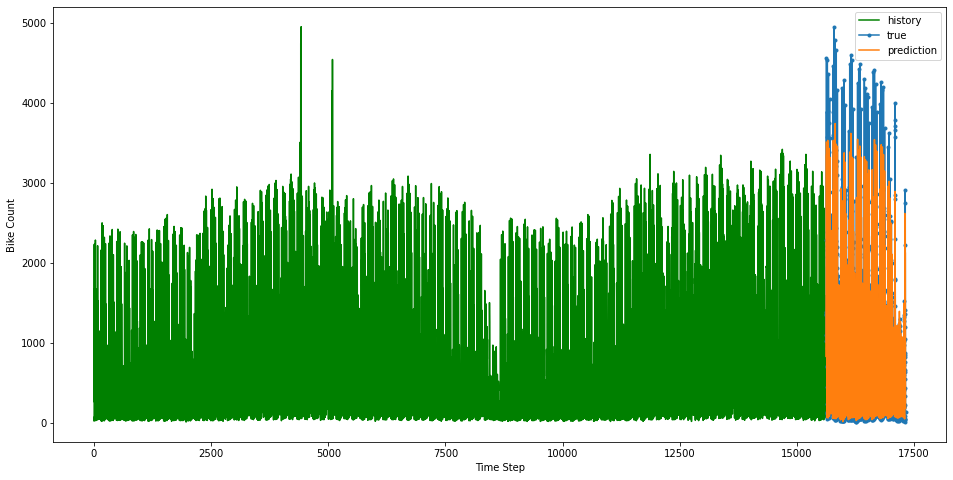

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_train_inv.shape

(1, 15624)

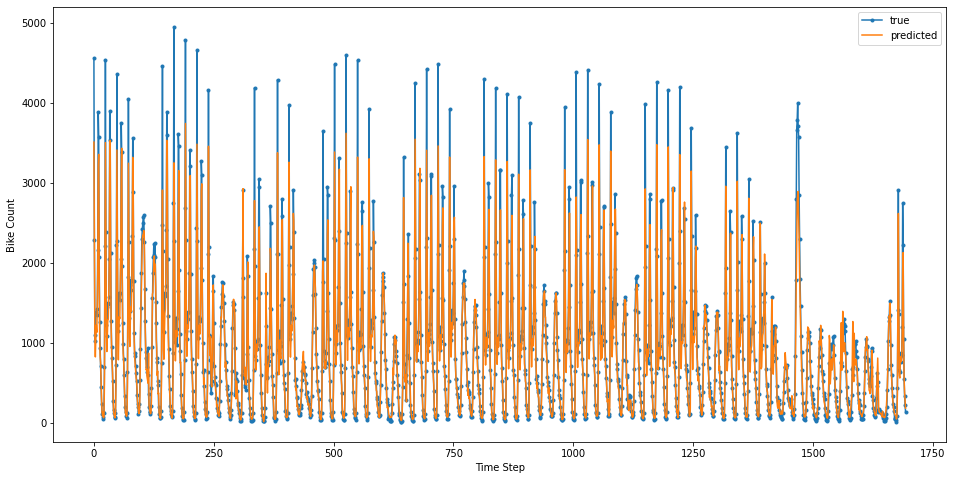

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_pred_test_inv

array([[3507.7112 ],
       [2351.9456 ],
       [1064.6718 ],
       ...,
       [ 381.69595],
       [ 289.48877],
       [ 181.67502]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 96.50 RMSE
Test Score: 234.93 RMSE


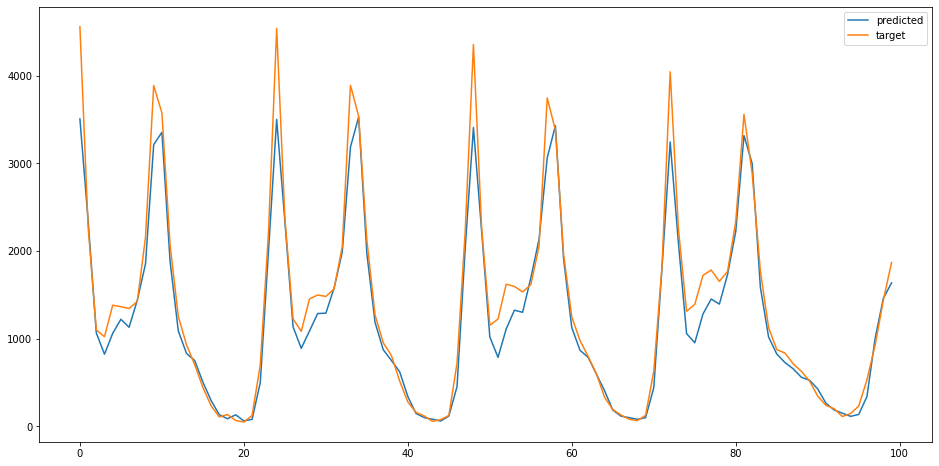

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

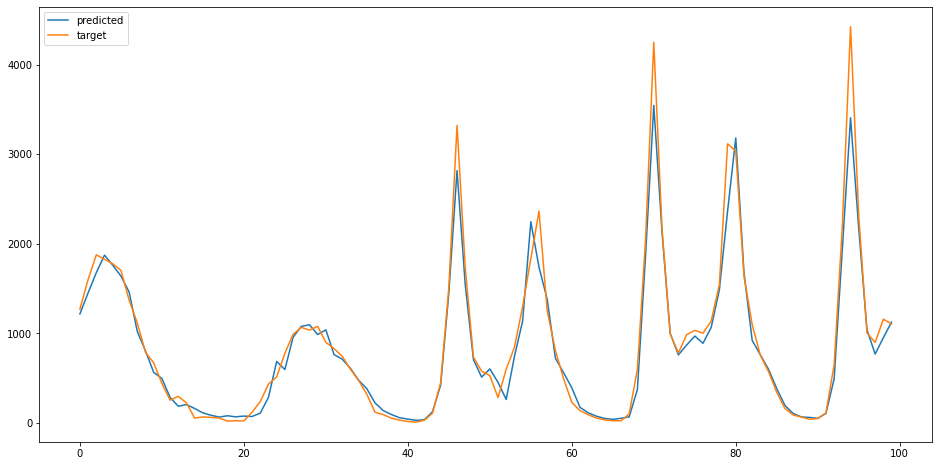

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

# LSTM 2 con datos 'cnt' escalados con RobustScaler

Modelo LSTM con dropout. Por ahora entreno con 10 epochs para ver que tal, ya que con los recursos computacionales disponibles se tarda mucho tiempo en entrenar. 

In [ ]:
def LSTM_model():
  model_lstm = Sequential()
  model_lstm.add(LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
  model_lstm.add(Dropout(rate=0.2))
  model_lstm.add(Dense(units=1)) # pasar a densa de 24
  model_lstm.compile(loss='mean_squared_error', optimizer='Adam')
  model_lstm.summary()

  return model_lstm


In [ ]:
model_lstm = LSTM_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               70144     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

Epoch 1/100
440/440 [==============================] - 9s 16ms/step - loss: 0.1966 - val_loss: 0.0693
Epoch 2/100
440/440 [==============================] - 7s 16ms/step - loss: 0.0535 - val_loss: 0.0350
Epoch 3/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0356 - val_loss: 0.0233
Epoch 4/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0296 - val_loss: 0.0453
Epoch 5/100
440/440 [==============================] - 8s 17ms/step - loss: 0.0276 - val_loss: 0.0280
Epoch 6/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0240 - val_loss: 0.0206
Epoch 7/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0231 - val_loss: 0.0291
Epoch 8/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0209 - val_loss: 0.0185
Epoch 9/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0212 - val_loss: 0.0175
Epoch 10/100
440/440 [==============================] - 7s 15ms/step - loss: 0.019

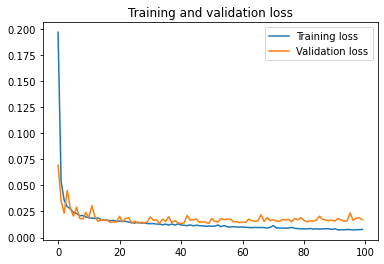

In [ ]:
plt.plot(history_lstm.history['loss'], label='Training loss')
plt.plot(history_lstm.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

Parece que el modelo aprende bien, sin embargo observamos que los datos de validación se estabilizan y los datos de train siguen reduciendo el error. 

¿DUDA, esto lo considero bueno o ajustaría más los hiperparámetros?

In [ ]:
# make predictions

y_pred_test = model_lstm.predict(X_test)
y_pred_train = model_lstm.predict(X_train)

In [ ]:
# invert scaling
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = cnt_transformer.inverse_transform(y_pred_test)
y_pred_train_inv = cnt_transformer.inverse_transform(y_pred_train)

print(y_train_inv.shape)
print(y_pred_test_inv.shape)
print(y_test_inv.shape)
print(y_pred_train_inv.shape)

(1, 15624)
(1694, 1)
(1, 1694)
(15624, 1)


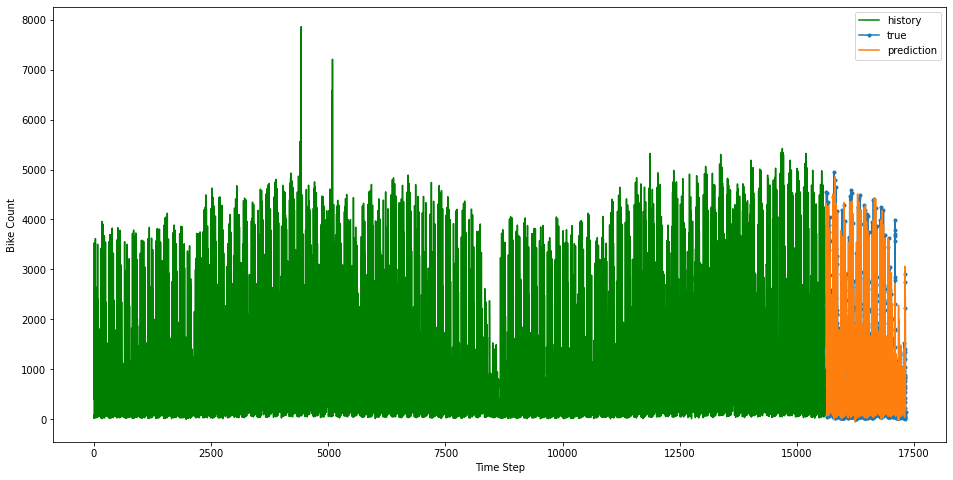

In [ ]:
'''
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();
'''
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

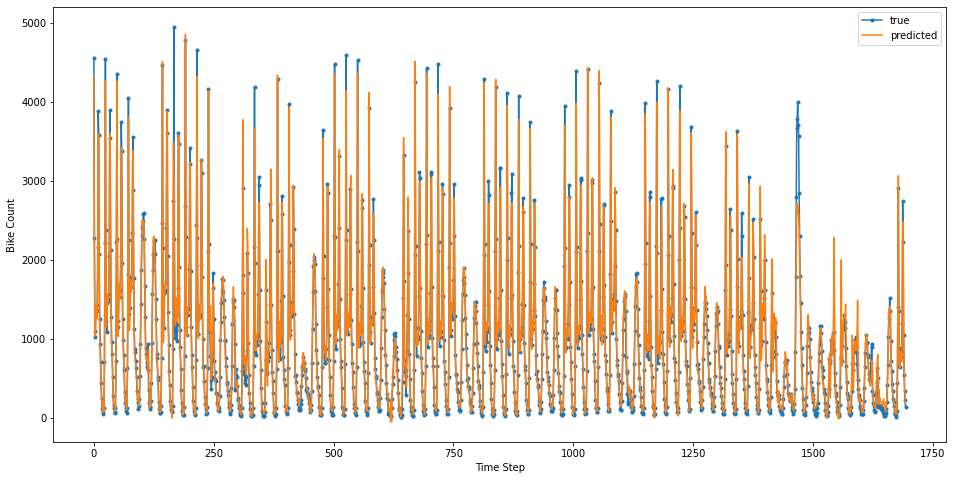

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [81]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score
import math

# calculate root mean squared error #R^2 
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

print(R2_score(y_train_inv[0], y_pred_train_inv[:,0]))
print(R2_score(y_test_inv[0], y_pred_test_inv[:,0]))

Train Score: 779554.28 RMSE
Test Score: 734496.13 RMSE
0.761652699400768
0.7015700697881857


In [77]:
170/1085

0.15668202764976957

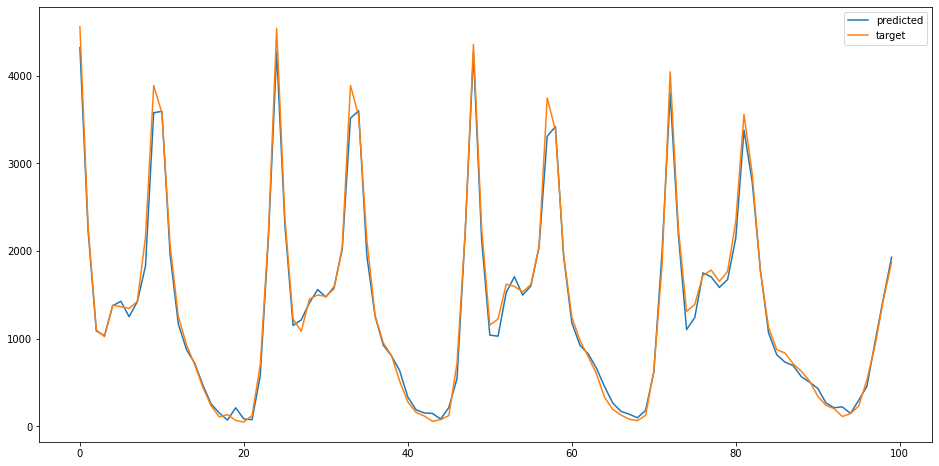

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

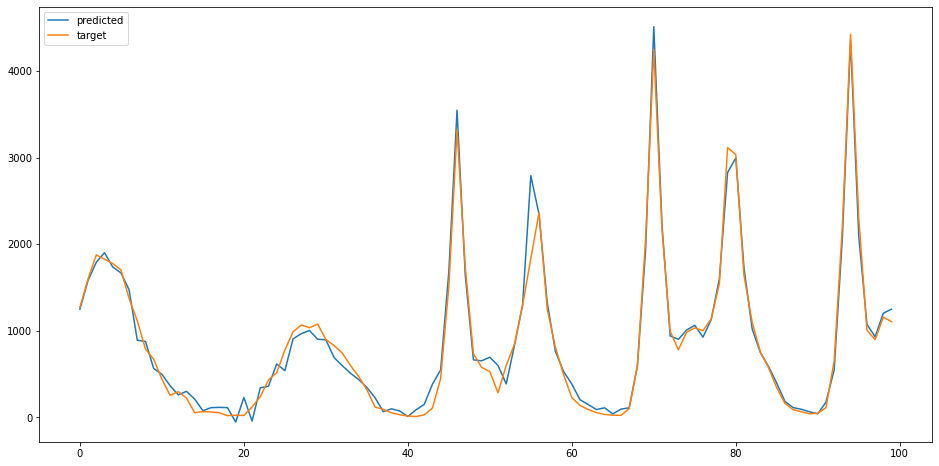

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

# LSTM BIDIRECTIONAL

## Escalando 'cnt' como RobustScaler

In [ ]:
def bidirectional_model():
  
  model_bid = Sequential()
  model_bid.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))
  model_bid.add(Dropout(rate=0.2))
  model_bid.add(Dense(units=1))
  model_bid.compile(loss='mean_squared_error', optimizer='adam')

  return model_bid

In [ ]:
model_bid = bidirectional_model()

In [ ]:
history_bid = model_bid.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

Epoch 1/100
440/440 [==============================] - 13s 30ms/step - loss: 0.0122 - val_loss: 0.0155
Epoch 2/100
440/440 [==============================] - 13s 28ms/step - loss: 0.0119 - val_loss: 0.0169
Epoch 3/100
440/440 [==============================] - 13s 28ms/step - loss: 0.0111 - val_loss: 0.0157
Epoch 4/100
440/440 [==============================] - 13s 28ms/step - loss: 0.0114 - val_loss: 0.0133
Epoch 5/100
440/440 [==============================] - 12s 28ms/step - loss: 0.0108 - val_loss: 0.0174
Epoch 6/100
440/440 [==============================] - 12s 28ms/step - loss: 0.0112 - val_loss: 0.0137
Epoch 7/100
440/440 [==============================] - 12s 28ms/step - loss: 0.0109 - val_loss: 0.0153
Epoch 8/100
440/440 [==============================] - 12s 28ms/step - loss: 0.0108 - val_loss: 0.0160
Epoch 9/100
440/440 [==============================] - 13s 29ms/step - loss: 0.0102 - val_loss: 0.0152
Epoch 10/100
440/440 [==============================] - 13s 28ms/step - l

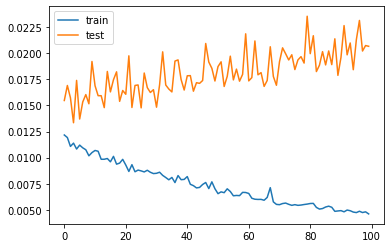

In [ ]:
plt.plot(history_bid.history['loss'], label='train')
plt.plot(history_bid.history['val_loss'], label='test')
plt.legend();

In [ ]:
# make predictions

y_pred_test = model_bid.predict(X_test)
y_pred_train = model_bid.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = cnt_transformer.inverse_transform(y_pred_test)
y_pred_train_inv = cnt_transformer.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)


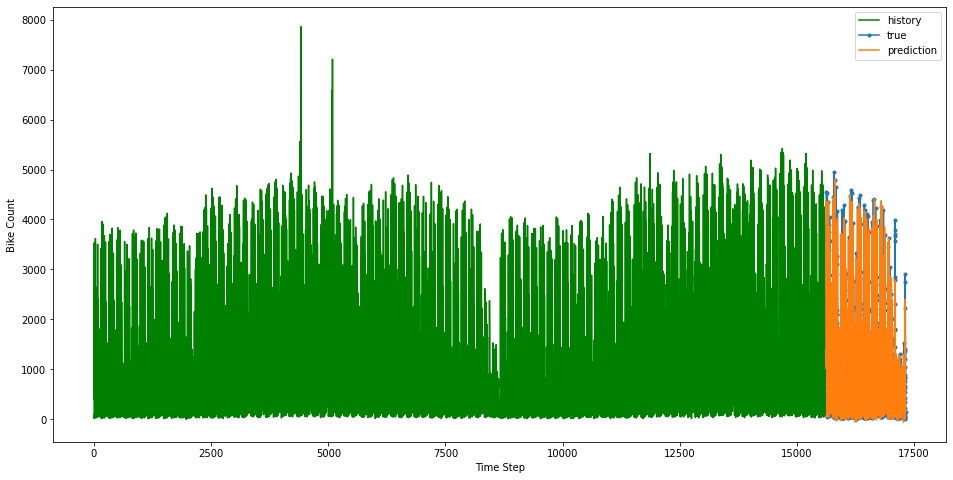

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

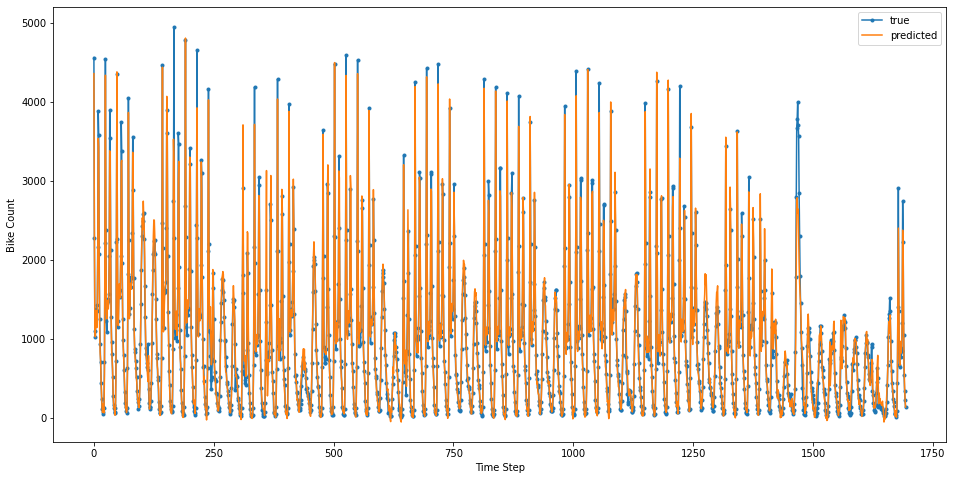

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 96.15 RMSE
Test Score: 171.93 RMSE


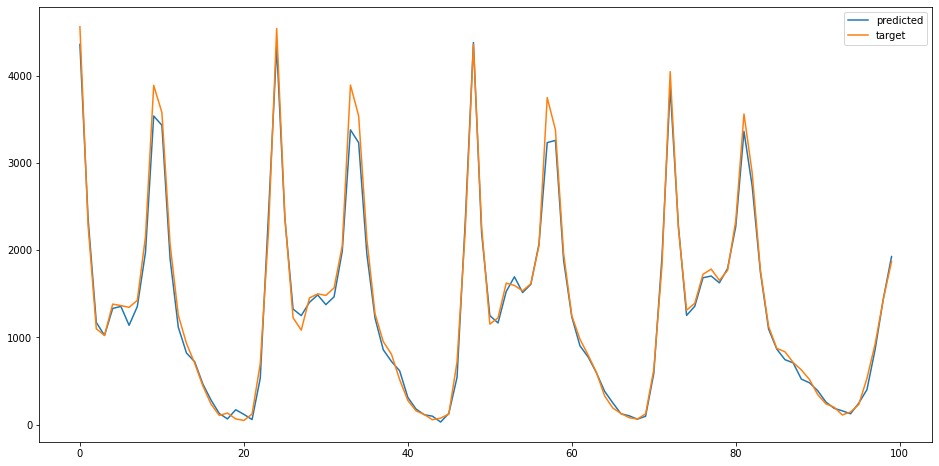

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

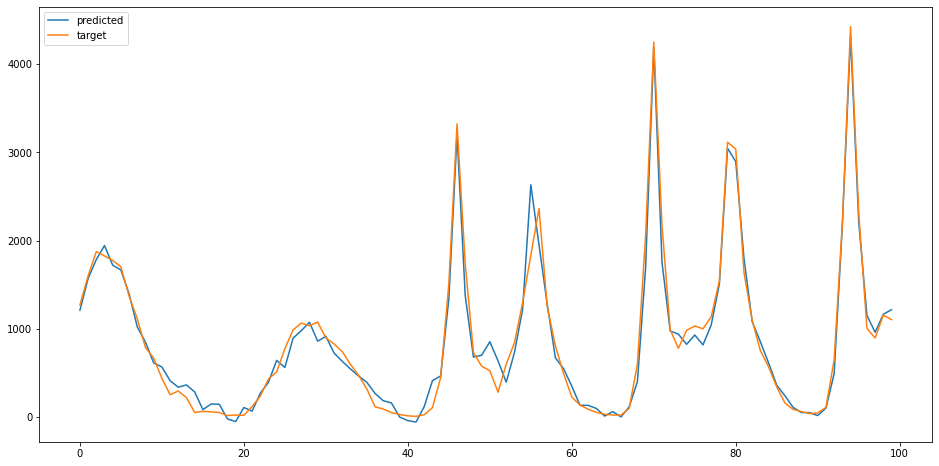

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

## Escalando 'cnt' como MinMaxScaler

In [ ]:
'''
VISUALIZACIONES CON MinMaxScaler 
'''

# make predictions

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)

'''
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
'''

'\ntrainPredict = scaler.inverse_transform(trainPredict)\ntrainY = scaler.inverse_transform([y_train])\ntestPredict = scaler.inverse_transform(testPredict)\ntestY = scaler.inverse_transform([y_test])\n'

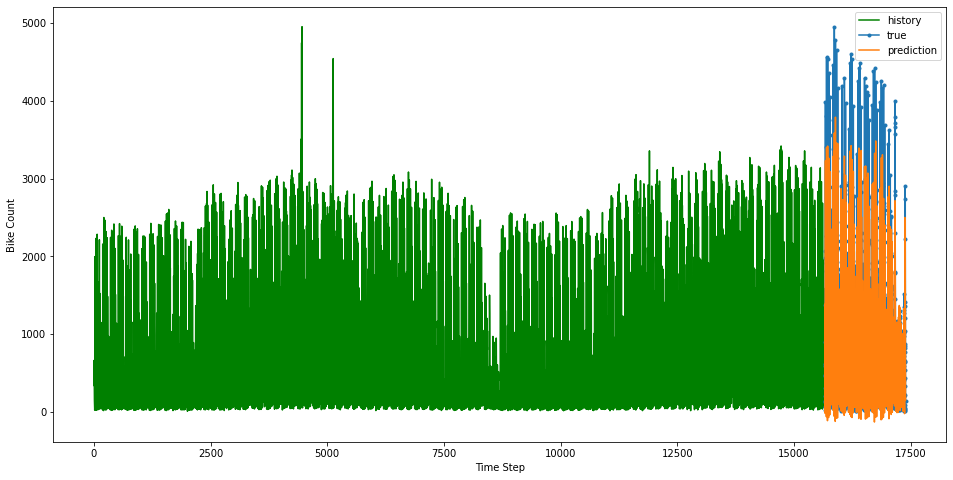

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

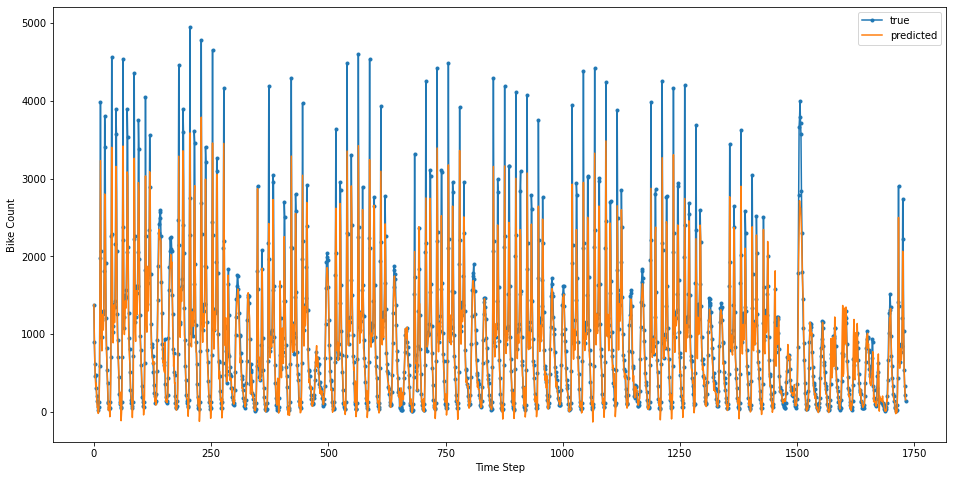

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_pred_test_inv

array([[1380.4135 ],
       [ 936.95795],
       [ 610.78827],
       ...,
       [ 354.1295 ],
       [ 238.64658],
       [ 157.14285]], dtype=float32)

In [ ]:
y_test_inv

array([[1376.,  894.,  615., ...,  337.,  224.,  139.]])

In [ ]:
y_pred_test_inv

array([[1380.4135 ],
       [ 936.95795],
       [ 610.78827],
       ...,
       [ 354.1295 ],
       [ 238.64658],
       [ 157.14285]], dtype=float32)

In [ ]:
y_pred_test_inv.flatten()

array([1380.4135 ,  936.95795,  610.78827, ...,  354.1295 ,  238.64658,
        157.14285], dtype=float32)

In [ ]:
y_pred_test_inv.shape

(1732, 1)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 103.15 RMSE
Test Score: 267.44 RMSE


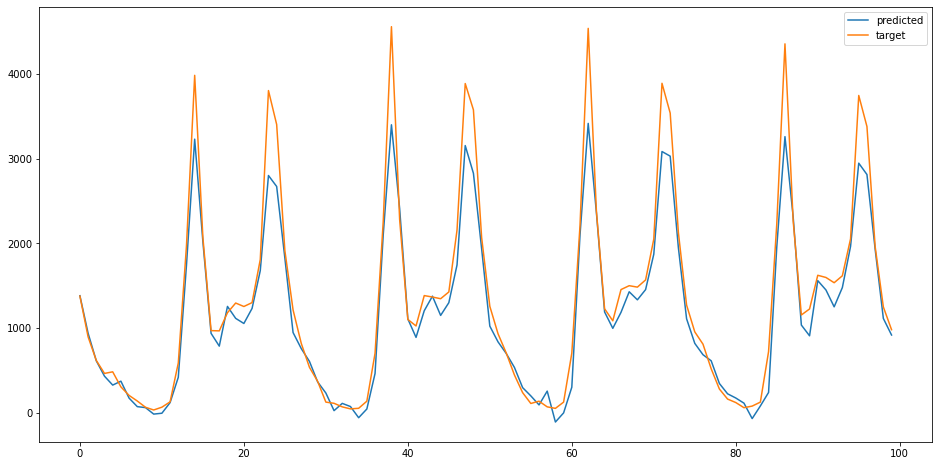

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

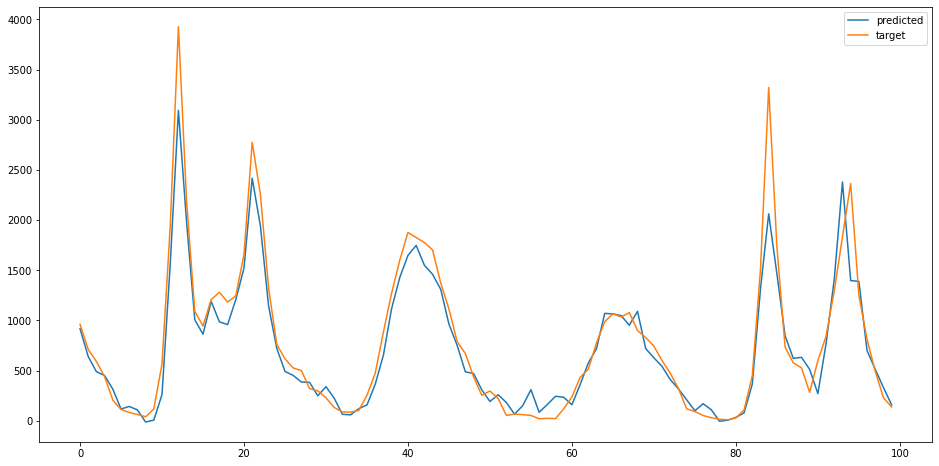

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

#Bidirectional TimeDistributed 

In [ ]:
#ESTA FORMA NO FUNCIONA
'''
from keras.layers.wrappers import TimeDistributed
def bidirectional_model_2():
  
  model_bid = Sequential()
  model_bid.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))
  model_bid.add(TimeDistributed(Dense(1, activation='sigmoid')))
  #model_bid.add(Dropout(rate=0.2))
  #model_bid.add(Dense(units=1))
  model_bid.compile(loss='mean_squared_error', optimizer='adam')

  return model_bid

'''
from keras.layers.wrappers import TimeDistributed

def bidirectional_model_3():
  model = Sequential()
  model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(TimeDistributed(Dense(1, activation='sigmoid')))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

  return model


model_bid_3 = bidirectional_model_3()



In [ ]:
history_bid_3 = model_bid_3.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

Epoch 1/100
440/440 [==============================] - 20s 27ms/step - loss: 0.5050 - acc: 7.8231e-04 - val_loss: 0.7246 - val_acc: 6.3980e-04
Epoch 2/100
440/440 [==============================] - 11s 24ms/step - loss: 0.4979 - acc: 7.8231e-04 - val_loss: 0.6882 - val_acc: 6.3980e-04
Epoch 3/100
440/440 [==============================] - 11s 24ms/step - loss: 0.4973 - acc: 7.8231e-04 - val_loss: 0.7258 - val_acc: 6.3980e-04
Epoch 4/100
440/440 [==============================] - 11s 24ms/step - loss: 0.4971 - acc: 7.8231e-04 - val_loss: 0.7384 - val_acc: 6.3980e-04
Epoch 5/100
440/440 [==============================] - 11s 24ms/step - loss: 0.4963 - acc: 7.8231e-04 - val_loss: 0.7623 - val_acc: 6.3980e-04
Epoch 6/100
440/440 [==============================] - 11s 25ms/step - loss: 0.4964 - acc: 7.8231e-04 - val_loss: 0.7375 - val_acc: 6.3980e-04
Epoch 7/100
440/440 [==============================] - 11s 24ms/step - loss: 0.4959 - acc: 7.8231e-04 - val_loss: 0.7215 - val_acc: 6.3980e-04

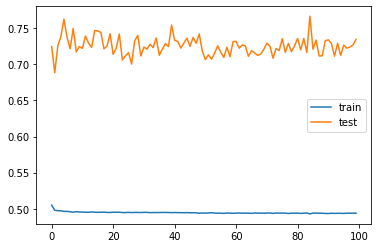

In [ ]:
plt.plot(history_bid_3.history['loss'], label='train')
plt.plot(history_bid_3.history['val_loss'], label='test')
plt.legend();

# GRU

In [62]:
model_gru = Sequential()
model_gru.add(GRU(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dense(units = 512, activation = 'relu'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units = 1, activation = 'linear')) #24
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 32)                4032      
                                                                 
 dense_6 (Dense)             (None, 512)               16896     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0
_________________________________________________________________


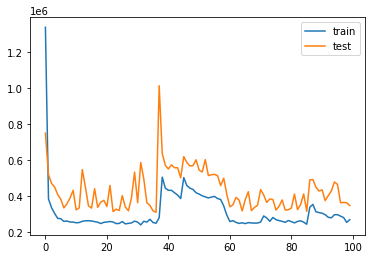

In [50]:
### ESTO ES UN ERROR, AL METER LOS DATOS SIN ESCALAR LA RED NO APRENDIA BIEN Y SOBREAJUSTABA ###
plt.plot(history_gru.history['loss'], label='train')
plt.plot(history_gru.history['val_loss'], label='test')
plt.legend();

In [63]:
model_gru.compile(loss='mean_squared_error', optimizer='adam')
history_gru = model_gru.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

Epoch 1/100
440/440 [==============================] - 7s 13ms/step - loss: 1420558.3750 - val_loss: 845332.8750
Epoch 2/100
440/440 [==============================] - 5s 11ms/step - loss: 425335.7188 - val_loss: 497923.3438
Epoch 3/100
440/440 [==============================] - 5s 11ms/step - loss: 348535.8438 - val_loss: 524395.6250
Epoch 4/100
440/440 [==============================] - 5s 11ms/step - loss: 327084.8750 - val_loss: 385631.9688
Epoch 5/100
440/440 [==============================] - 5s 11ms/step - loss: 290389.6875 - val_loss: 423143.0938
Epoch 6/100
440/440 [==============================] - 5s 11ms/step - loss: 302610.0000 - val_loss: 463688.1562
Epoch 7/100
440/440 [==============================] - 5s 11ms/step - loss: 344845.0312 - val_loss: 505465.9062
Epoch 8/100
440/440 [==============================] - 5s 12ms/step - loss: 298708.9375 - val_loss: 409816.8438
Epoch 9/100
440/440 [==============================] - 5s 11ms/step - loss: 282775.3438 - val_loss: 367

Aparentemente tenemos un entrenamiento correcto donde el modelo ha aprendido bastante bien ya que tanto el validation loss como el train loss decrecen y se estabilizan alrededor del mismo punto, siendo este alrededor de 0.02

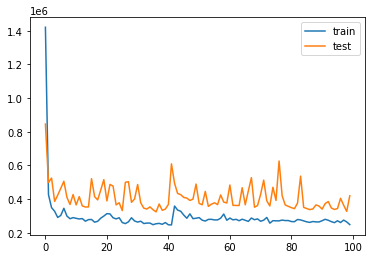

In [67]:
### SOBREAJUSTABA ###
plt.plot(history_gru.history['loss'], label='train')
plt.plot(history_gru.history['val_loss'], label='test')
plt.legend();

In [68]:
# make predictions
y_pred_test = model_gru.predict(X_test)
y_pred_train = model_gru.predict(X_train)

In [69]:
# invert scaling

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = cnt_transformer.inverse_transform(y_pred_test)
y_pred_train_inv = cnt_transformer.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)


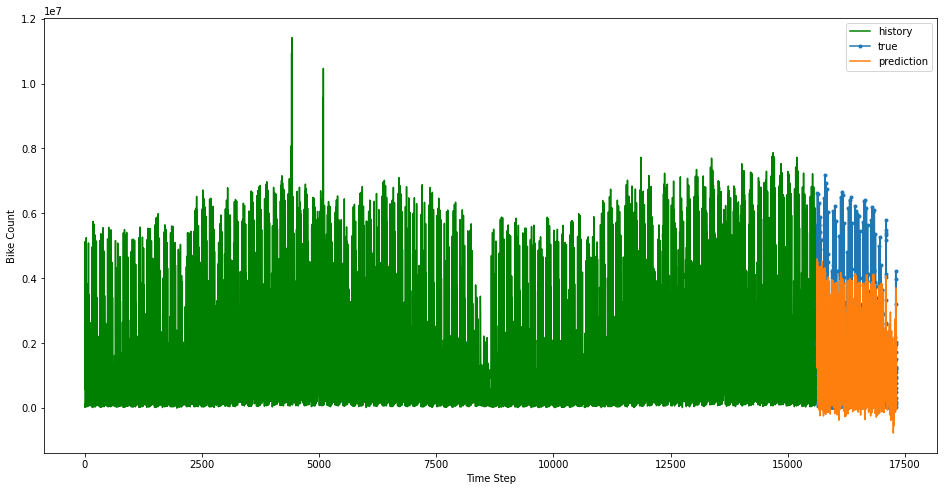

In [70]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

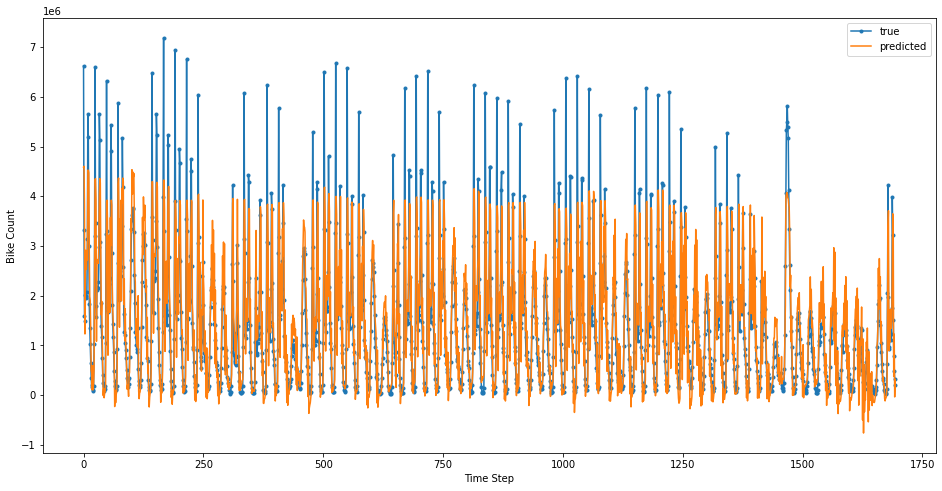

In [71]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [72]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 779554.28 RMSE
Test Score: 734496.13 RMSE


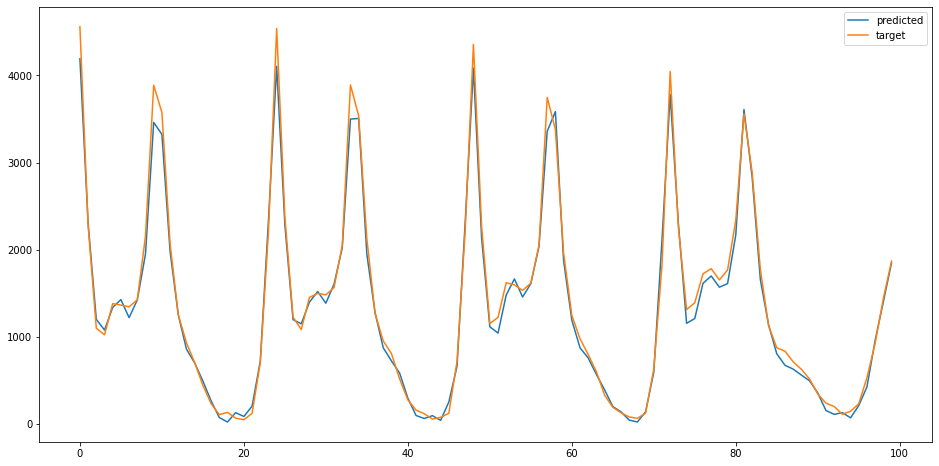

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

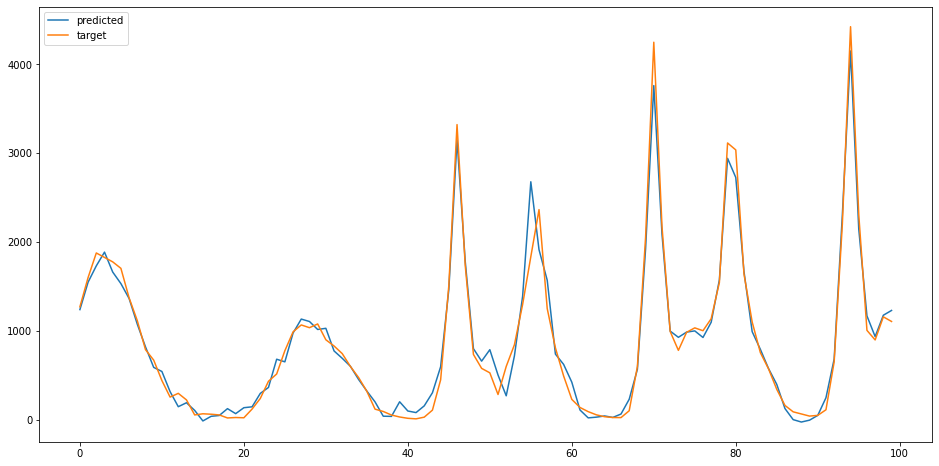

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

# RESUMEN RMSE

In [ ]:
# NO TOCAR SINO SE ACTUALIZA Y SE PIERDE EL NÚMERO

In [ ]:
########## LSTM ##########
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 112.20 RMSE
Test Score: 170.35 RMSE


In [ ]:
########## GRU ##########
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 157.13 RMSE
Test Score: 145.36 RMSE
